## 🧩 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score

## 📁 2. Load Data

In [4]:
features=pd.read_csv('training_set_features.csv')
labels=pd.read_csv('training_set_labels.csv')
test_features=pd.read_csv('test_set_features.csv')
submission_format=pd.read_csv('submission_format.csv')

In [5]:
print("Train Shape:",features.shape)
print("labels Shape:",labels.shape)
print("Test shape:",test_features.shape)

Train Shape: (26707, 36)
labels Shape: (26707, 3)
Test shape: (26708, 36)


## 🧹 3. Preprocessing

In [7]:
X=features.copy()
y=labels[["h1n1_vaccine", "seasonal_vaccine"]]
X_test=test_features.copy()

## Identify columns

In [9]:
categorical_cols=X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols=X.select_dtypes(include=["int64","float64"]).columns.tolist()
numerical_cols.remove("respondent_id")

## Define Transformers

In [11]:
numerical_pipeline=Pipeline([
    ("imputer",SimpleImputer(strategy="mean")),
    ("scaler",StandardScaler())
    ])

In [12]:
categorical_pipeline=Pipeline([
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(handle_unknown="ignore"))
     ])

## Combine

In [14]:
preprocessor=ColumnTransformer([
    ("num",numerical_pipeline,numerical_cols),
    ("cat",categorical_pipeline,categorical_cols)
])

## ⚙️ 4. Build Model Pipeline

In [16]:
model=Pipeline([
    ("preprocess",preprocessor),
    ("clf",MultiOutputClassifier(LogisticRegression(max_iter=1000)))
     ])  

## 📚 5. Train/Validation Split

In [18]:
 X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42)

## 🚂 6. Train the Model

In [20]:
model.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_fa...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000)))])

## 🧪 7. Evaluate the Model

In [22]:
y_pred_proba=model.predict_proba(X_val)
h1n1_preds=y_pred_proba[0][:,1]
seasonal_preds=y_pred_proba[1][:,1]

auc_h1n1=roc_auc_score(y_val["h1n1_vaccine"],h1n1_preds)
auc_seasonal=roc_auc_score(y_val["seasonal_vaccine"],seasonal_preds)

print("H1N1 AUC score:",auc_h1n1)
print("Seasonal AUC score:",auc_seasonal)
print("Mean AUC score:",(auc_h1n1+auc_seasonal)/2)

H1N1 AUC score: 0.8344937347149736
Seasonal AUC score: 0.8564396237510834
Mean AUC score: 0.8454666792330285


## 📈 8. Plot ROC Predictions

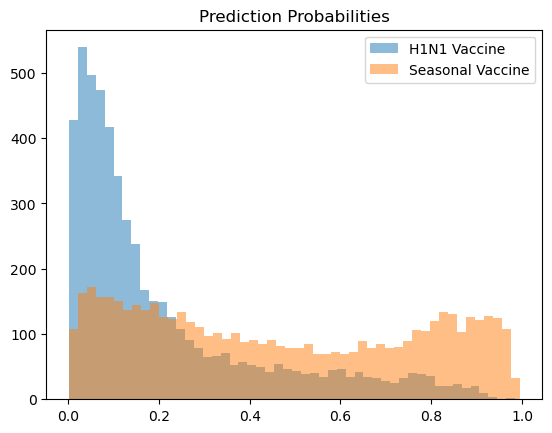

In [24]:
plt.hist(h1n1_preds,bins=50,alpha=0.5,label="H1N1 Vaccine")
plt.hist(seasonal_preds,bins=50,alpha=0.5,label="Seasonal Vaccine")
plt.legend()
plt.title("Prediction Probabilities")
plt.show()

## ✅ 9. Final Prediction on Test Set

In [26]:
final_preds=model.predict_proba(X_test)
submission =pd.DataFrame({
    "respondent_id":X_test["respondent_id"],
    "h1n1_vaccine":final_preds[0][:,1],
    "seasonal_vaccine":final_preds[1][:,1]
})

submission = submission.sort_values(by="respondent_id")

In [27]:
submission

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.057140,0.311367
1,26708,0.020364,0.038351
2,26709,0.411252,0.512837
3,26710,0.511766,0.873231
4,26711,0.168795,0.458008
...,...,...,...
26703,53410,0.299361,0.468659
26704,53411,0.041815,0.237444
26705,53412,0.158667,0.205217
26706,53413,0.057188,0.347320


## 💾 10. Save Submission

In [29]:
submission.to_csv("submission.csv",index=False)